In [1]:
# import libraries
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import time
try:
    import cPickle
except:
    import pickle
from collections import Counter
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

In [2]:
# save sentences line by line in a list

def read_sentences(file_path):
    sentences = []
    with open(file_path, 'r', encoding = 'utf-8') as reader:
        sentences = reader.readlines()
    return sentences

en_sentences = read_sentences('C:\\Users\\vatsa\\Downloads\\CS533\\Project\\data\\europarl-v7.de-en.en')
de_sentences = read_sentences('C:\\Users\\vatsa\\Downloads\\CS533\\Project\\data\\europarl-v7.de-en.de')

len(en_sentences), len(de_sentences)

(1920209, 1920209)

In [3]:
def create_dataset(en_sentences, de_sentences):

    en_vocab_dict = Counter(word.strip(',." ;:)(][?!') for sentence in en_sentences for word in sentence.split())
    de_vocab_dict = Counter(word.strip(',." ;:)(][?!') for sentence in de_sentences for word in sentence.split())

    en_vocab = list(map(lambda x: x[0], sorted(en_vocab_dict.items(), key = lambda x: -x[1])))
    de_vocab = list(map(lambda x: x[0], sorted(de_vocab_dict.items(), key = lambda x: -x[1])))

    en_vocab = en_vocab[:100000]
    de_vocab = de_vocab[:100000]

    start_idx = 2
    en_word2idx = dict([(word, idx+start_idx) for idx, word in enumerate(en_vocab)])
    en_word2idx['<ukn>'] = 0
    en_word2idx['<pad>'] = 1
    en_idx2word = dict([(idx, word) for word, idx in en_word2idx.items()])

    start_idx = 4
    de_word2idx = dict([(word, idx+start_idx) for idx, word in enumerate(de_vocab)])
    de_word2idx['<ukn>'] = 0
    de_word2idx['<go>']  = 1 # start tag used to detect beginning of sentence in german. Not needed for encoder
    de_word2idx['<eos>'] = 2 # end tag used to detect end of sentence in german. Not needed for encoder
    de_word2idx['<pad>'] = 3
    de_idx2word = dict([(idx, word) for word, idx in de_word2idx.items()])

    x = [[en_word2idx.get(word.strip(',." ;:)(][?!'), 0) for word in sentence.split()] for sentence in en_sentences]
    y = [[de_word2idx.get(word.strip(',." ;:)(][?!'), 0) for word in sentence.split()] for sentence in de_sentences]
    X = []
    Y = []
    for i in range(len(x)):
        n1 = len(x[i])
        n2 = len(y[i])
        n = n1 if n1 < n2 else n2 
        if abs(n1 - n2) <= 0.3 * n:
            if n1 <= 40 and n2 <= 40:
                X.append(x[i])
                Y.append(y[i])
    return X, Y, en_word2idx, en_idx2word, en_vocab, de_word2idx, de_idx2word, de_vocab

In [4]:
def save_dataset(file_path, obj):
    with open(file_path, 'wb') as f:
        pickle.dump(obj, f, -1)

save_dataset('./data.pkl', create_dataset(en_sentences, de_sentences))

def read_dataset(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)
    
X, Y, en_word2idx, en_idx2word, en_vocab, de_word2idx, de_idx2word, de_vocab = read_dataset('data.pkl')

In [5]:
# inspect data
print ('Sentence in English - encoded:', X[2])
print ('Sentence in German - encoded:', Y[2])
print ('Decoded:\n------------------------')

for i in range(len(X[2])):
    print (en_idx2word[X[2][i]], end=" ")

print ('\n')

for i in range(len(Y[2])):
    print (de_idx2word[Y[2][i]], end=" ")

Sentence in English - encoded: [3163, 1210, 203, 10, 14, 13229, 314, 3608]
Sentence in German - encoded: [30, 621, 49, 28, 8, 46, 8938, 8, 3046]
Decoded:
------------------------
Please rise then for this minute' s silence 

Ich bitte Sie sich zu einer Schweigeminute zu erheben 

In [6]:
def data_padding(x, y, length = 40):
    for i in range(len(x)):
        x[i] = x[i] + (length - len(x[i])) * [en_word2idx['<pad>']]
        y[i] = [de_word2idx['<go>']] + y[i] + [de_word2idx['<eos>']] + (length-len(y[i])) * [de_word2idx['<pad>']]

data_padding(X, Y)

X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

del X
del Y

In [7]:
input_seq_len = 40
output_seq_len = 42
en_vocab_size = len(en_vocab) + 2 # + <pad>, <ukn>
de_vocab_size = len(de_vocab) + 4 # + <pad>, <ukn>, <eos>, <go>

# placeholders
encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

targets = [decoder_inputs[i+1] for i in range(output_seq_len-1)]
# add one more target
targets.append(tf.placeholder(dtype = tf.int32, shape = [None], name = 'last_target'))
target_weights = [tf.placeholder(dtype = tf.float32, shape = [None], name = 'target_w{}'.format(i)) for i in range(output_seq_len)]

# output projection
size = 512
w_t = tf.get_variable('proj_w', [de_vocab_size, size], tf.float32)
b = tf.get_variable('proj_b', [de_vocab_size], tf.float32)
w = tf.transpose(w_t)
output_projection = (w, b)

outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                            encoder_inputs,
                                            decoder_inputs,
                                            tf.contrib.rnn.BasicLSTMCell(size),
                                            num_encoder_symbols = en_vocab_size,
                                            num_decoder_symbols = de_vocab_size,
                                            embedding_size = 100,
                                            feed_previous = False,
                                            output_projection = output_projection,
                                            dtype = tf.float32)

In [8]:
# define our loss function

# sampled softmax loss - returns: A batch_size 1-D tensor of per-example sampled softmax losses
def sampled_loss(labels, logits):
    return tf.nn.sampled_softmax_loss(
                        weights = w_t,
                        biases = b,
                        labels = tf.reshape(labels, [-1, 1]),
                        inputs = logits,
                        num_sampled = 512,
                        num_classes = de_vocab_size)

# Weighted cross-entropy loss for a sequence of logits
loss = tf.contrib.legacy_seq2seq.sequence_loss(outputs, targets, target_weights, softmax_loss_function = sampled_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [9]:
# let's define some helper functions

# simple softmax function
def softmax(x):
    n = np.max(x)
    e_x = np.exp(x - n)
    return e_x / e_x.sum()

# feed data into placeholders
def feed_dict(x, y, batch_size = 64):
    feed = {}
    
    idxes = np.random.choice(len(x), size = batch_size, replace = False)
    
    for i in range(input_seq_len):
        feed[encoder_inputs[i].name] = np.array([x[j][i] for j in idxes], dtype = np.int32)
        
    for i in range(output_seq_len):
        feed[decoder_inputs[i].name] = np.array([y[j][i] for j in idxes], dtype = np.int32)
        
    feed[targets[len(targets)-1].name] = np.full(shape = [batch_size], fill_value = de_word2idx['<pad>'], dtype = np.int32)
    
    for i in range(output_seq_len-1):
        batch_weights = np.ones(batch_size, dtype = np.float32)
        target = feed[decoder_inputs[i+1].name]
        for j in range(batch_size):
            if target[j] == de_word2idx['<pad>']:
                batch_weights[j] = 0.0
        feed[target_weights[i].name] = batch_weights
        
    feed[target_weights[output_seq_len-1].name] = np.zeros(batch_size, dtype = np.float32)
    
    return feed

# decode output sequence
def decode_output(output_seq):
    words = []
    for i in range(output_seq_len):
        smax = softmax(output_seq[i])
        idx = np.argmax(smax)
        words.append(de_idx2word[idx])
    return words

In [14]:
# ops and hyperparameters
learning_rate = 5e-3
batch_size = 64
steps = 2500

# ops for projecting outputs
outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

# training op
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# init op
init = tf.global_variables_initializer()

# forward step
def forward_step(sess, feed):
    output_sequences = sess.run(outputs_proj, feed_dict = feed)
    return output_sequences

# training step
def backward_step(sess, feed):
    sess.run(optimizer, feed_dict = feed)

In [11]:
# let's train the model

# we will use this list to plot losses through steps
losses = []

# save a checkpoint so we can restore the model later 
saver = tf.train.Saver()

print ('------------------TRAINING------------------')

with tf.Session() as sess:
    sess.run(init)
    
    t = time.time()
    for step in range(steps):
        feed = feed_dict(X_train, Y_train)
            
        backward_step(sess, feed)
        
        if step % 5 == 4 or step == 0:
            loss_value = sess.run(loss, feed_dict = feed)
            print ('step: {}, loss: {}'.format(step, loss_value))
            losses.append(loss_value)
        
        if step % 20 == 19:
            saver.save(sess, 'checkpoints/', global_step=step)
            print ('Checkpoint is saved')
            
    print ('Training time for {} steps: {}s'.format(steps, time.time() - t))

------------------TRAINING------------------
step: 0, loss: 9.911262512207031
step: 4, loss: 9.896167755126953
step: 9, loss: 9.885457038879395
step: 14, loss: 9.908164024353027
step: 19, loss: 9.938472747802734
Checkpoint is saved
step: 24, loss: 9.915271759033203
step: 29, loss: 9.941328048706055
step: 34, loss: 9.894632339477539
step: 39, loss: 9.841753005981445
Checkpoint is saved
step: 44, loss: 9.804807662963867
step: 49, loss: 9.748702049255371
step: 54, loss: 9.686172485351562
step: 59, loss: 9.282543182373047
Checkpoint is saved
step: 64, loss: 8.424149513244629
step: 69, loss: 7.651979446411133
step: 74, loss: 7.711560249328613
step: 79, loss: 7.148109436035156
Checkpoint is saved
step: 84, loss: 6.980451583862305
step: 89, loss: 6.807934761047363
step: 94, loss: 7.455887794494629
step: 99, loss: 6.36277961730957
Checkpoint is saved
step: 104, loss: 6.61954402923584
step: 109, loss: 6.206734657287598
step: 114, loss: 6.342323303222656
step: 119, loss: 6.127676486968994
Checkp

step: 1019, loss: 2.2640016078948975
Checkpoint is saved
step: 1024, loss: 2.0340726375579834
step: 1029, loss: 2.4034717082977295
step: 1034, loss: 2.3374979496002197
step: 1039, loss: 2.4103236198425293
Checkpoint is saved
step: 1044, loss: 2.675180435180664
step: 1049, loss: 2.0938820838928223
step: 1054, loss: 2.3074140548706055
step: 1059, loss: 2.4116368293762207
Checkpoint is saved
step: 1064, loss: 2.0223608016967773
step: 1069, loss: 2.4092493057250977
step: 1074, loss: 2.2447595596313477
step: 1079, loss: 2.0402650833129883
Checkpoint is saved
step: 1084, loss: 2.2536187171936035
step: 1089, loss: 2.371462345123291
step: 1094, loss: 2.2895302772521973
step: 1099, loss: 2.0741422176361084
Checkpoint is saved
step: 1104, loss: 2.389817714691162
step: 1109, loss: 2.213097333908081
step: 1114, loss: 2.1745100021362305
step: 1119, loss: 2.106513023376465
Checkpoint is saved
step: 1124, loss: 2.265883207321167
step: 1129, loss: 2.2433042526245117
step: 1134, loss: 2.231176853179931

Checkpoint is saved
step: 2004, loss: 1.5810883045196533
step: 2009, loss: 1.4909790754318237
step: 2014, loss: 1.7791677713394165
step: 2019, loss: 1.5257623195648193
Checkpoint is saved
step: 2024, loss: 1.4997544288635254
step: 2029, loss: 1.7327592372894287
step: 2034, loss: 1.4393284320831299
step: 2039, loss: 1.5061869621276855
Checkpoint is saved
step: 2044, loss: 1.3929513692855835
step: 2049, loss: 1.6205239295959473
step: 2054, loss: 1.3990164995193481
step: 2059, loss: 1.4685313701629639
Checkpoint is saved
step: 2064, loss: 1.4276872873306274
step: 2069, loss: 1.576460599899292
step: 2074, loss: 1.5305659770965576
step: 2079, loss: 1.683668613433838
Checkpoint is saved
step: 2084, loss: 1.309368371963501
step: 2089, loss: 1.4812687635421753
step: 2094, loss: 1.4720590114593506
step: 2099, loss: 1.5217511653900146
Checkpoint is saved
step: 2104, loss: 1.5398826599121094
step: 2109, loss: 1.5198982954025269
step: 2114, loss: 1.254844307899475
step: 2119, loss: 1.5853968858718

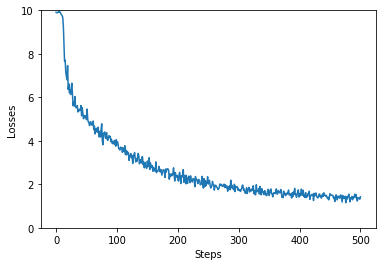

In [15]:
# plot losses

plt.plot(losses)
plt.xlabel('Steps')
plt.ylabel('Losses')
plt.ylim((0, 10))
plt.show()

In [16]:
# let's test the model
gen_out = ''
total_bleu_score = []

with tf.Graph().as_default():
    
    # placeholders
    encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
    decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

    # output projection
    size = 512
    w_t = tf.get_variable('proj_w', [de_vocab_size, size], tf.float32)
    b = tf.get_variable('proj_b', [de_vocab_size], tf.float32)
    w = tf.transpose(w_t)
    output_projection = (w, b)
    
    # change the model so that output at time t can be fed as input at time t+1
    outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                                encoder_inputs,
                                                decoder_inputs,
                                                tf.contrib.rnn.BasicLSTMCell(size),
                                                num_encoder_symbols = en_vocab_size,
                                                num_decoder_symbols = de_vocab_size,
                                                embedding_size = 100,
                                                feed_previous = True, # <-----this is changed----->
                                                output_projection = output_projection,
                                                dtype = tf.float32)
    
    # ops for projecting outputs
    outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

    # let's translate these sentences     
    en_sentences = read_sentences('C:\\Users\\vatsa\\Downloads\\CS533\\Project\\test_data\\testen.txt')
    de_sentences = read_sentences('C:\\Users\\vatsa\\Downloads\\CS533\\Project\\test_data\\testde.txt')
    en_sentences_encoded = [[en_word2idx.get(word, 0) for word in en_sentence.split()] for en_sentence in en_sentences]
    
    # padding to fit encoder input
    for i in range(len(en_sentences_encoded)):
        en_sentences_encoded[i] += (40 - len(en_sentences_encoded[i])) * [en_word2idx['<pad>']]
    
    # restore all variables - use the last checkpoint saved
    saver = tf.train.Saver()
    path = tf.train.latest_checkpoint('checkpoints')
    
    with tf.Session() as sess:
        # restore
        saver.restore(sess, path)
        
        # feed data into placeholders
        feed = {}
        for i in range(input_seq_len):
            feed[encoder_inputs[i].name] = np.array([en_sentences_encoded[j][i] for j in range(len(en_sentences_encoded))], dtype = np.int32)
            
        feed[decoder_inputs[0].name] = np.array([de_word2idx['<go>']] * len(en_sentences_encoded), dtype = np.int32)
        
        # translate
        output_sequences = sess.run(outputs_proj, feed_dict = feed)
        
        # decode seq.
        for i in range(len(en_sentences_encoded)):
            print ('{}.\n--------------------------------'.format(i+1))
            ouput_seq = [output_sequences[j][i] for j in range(output_seq_len)]
            #decode output sequence
            words = decode_output(ouput_seq)
            print ('English sentence: ', en_sentences[i])
            print('Expected translation: ', de_sentences[i])
            print('Generated output: ')
            for k in range(len(words)):
                if words[k] not in ['<eos>', '<pad>', '<go>']:
                    print (words[k], end=" ")
                    gen_out += ' ' + words[k]
            score = sentence_bleu(de_sentences[i], gen_out) 
            print('\nBleu score: ', score)
            total_bleu_score.append(score)
            gen_out = ''
            print ('\n--------------------------------')

print('\nAverage BLEU score is', np.mean(total_bleu_score))

INFO:tensorflow:Restoring parameters from checkpoints\-2499
1.
--------------------------------
English sentence:  ﻿Why are no-smoking areas not enforced?

Expected translation:  ﻿Warum wird in den Nichtraucherzonen das Rauchverbot nicht durchgesetzt?

Generated output: 
Die <ukn> sind nicht <ukn> 
Bleu score:  0.7801157731069053

--------------------------------
2.
--------------------------------
English sentence:  That was the decision.

Expected translation:  Das war der Beschluß.

Generated output: 
Das war die <ukn> 
Bleu score:  0.8408964152537145

--------------------------------
3.
--------------------------------
English sentence:  All of the others were of a different opinion.

Expected translation:  Alle anderen waren anderer Meinung.

Generated output: 
Alle anderen der anderen waren ein anderes 
Bleu score:  0.6944370541455951

--------------------------------
4.
--------------------------------
English sentence:  This gives them a competitive edge for the interim period.

C:\ProgramData\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


English sentence:  In addition, the need for greater transparency has been pointed out.

Expected translation:  Darüber hinaus wird auf die Notwendigkeit einer verstärkten Transparenz hingewiesen.

Generated output: 
Im Dezember <ukn> ist mehr Transparenz <ukn> <ukn> 
Bleu score:  0.748406329216425

--------------------------------
7.
--------------------------------
English sentence:  Transport of dangerous goods by road

Expected translation:  Sicherheitsberater für den Gefahrguttransport

Generated output: 
Die gefährlichen von Straße 
Bleu score:  0.8254605646966103

--------------------------------
8.
--------------------------------
English sentence:  Some speakers have already mentioned unemployment and the fall in population.

Expected translation:  Einige Kollegen haben bereits über die Arbeitslosigkeit und den Bevölkerungsrückgang gesprochen.

Generated output: 
Einige Redner haben Arbeitslosigkeit und die <ukn> erwähnt 
Bleu score:  0.7431990115298822

----------------------